感知机:
输入x1 - xn;
输出f(x)分类: 感知机最多完成一个二分类问题
早起感知机的算法:
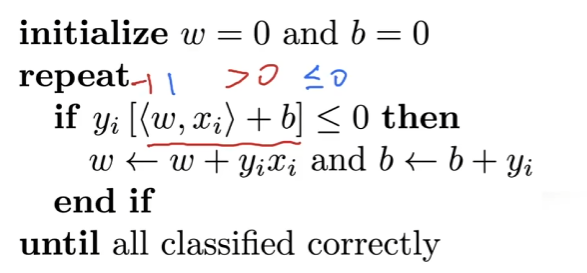
如果预测失败(结果与实值积为负), 就更新w, b
相当于有一条分界线, 每次分类失败就修改分界线, 最终达成成功分类
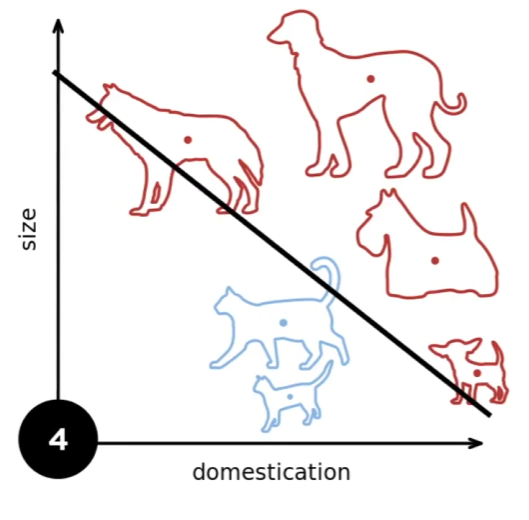

感知机的收敛定理:
对于分类:
数据在半径为r的区域内
如果存在一个余量ρ, 使得存在一个分界面, 对于(w^2 + b^2<=1)的w, b, 使得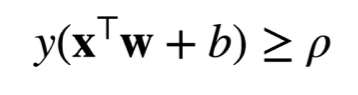(也就是对所有的分类都是正确的)
则, 感知机保证在(r^2+1)/ρ^2步后收敛

感知机不能拟合异或函数, 就想一条线不能将一三象限和二四象限分开: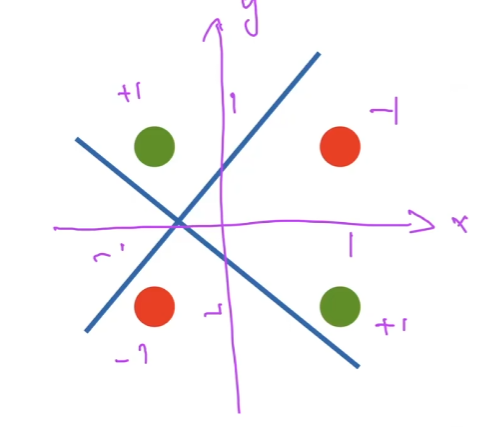

如何利用感知机解决XOR问题? 多层感知机:
简单来说, 画两条线, 统计两条线的结果, 得到XOR的结果: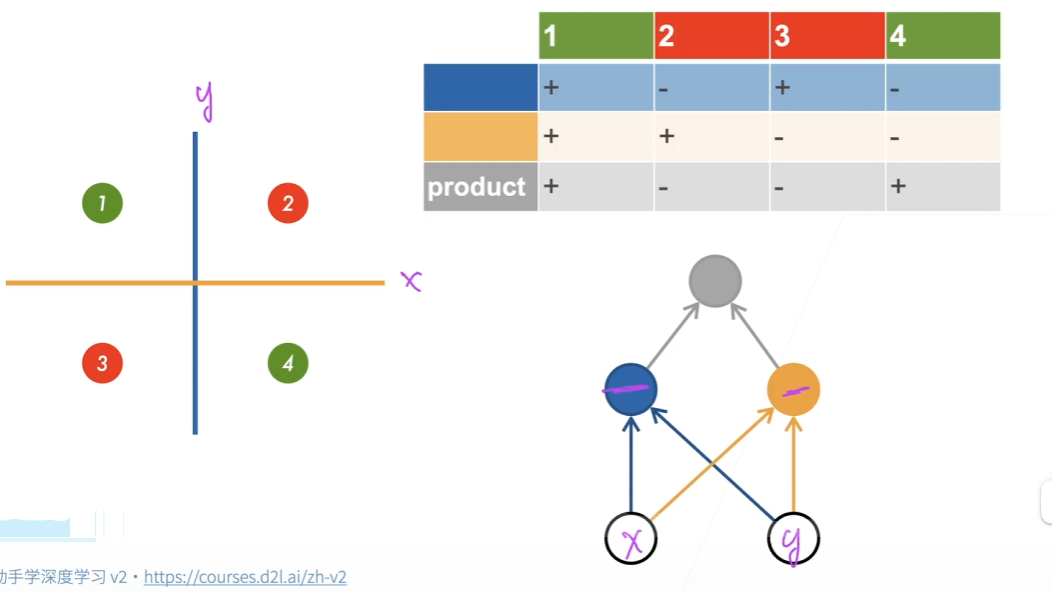

输入层 => 隐藏层 => 输出层;
隐藏层的大小和隐藏层数是超参数
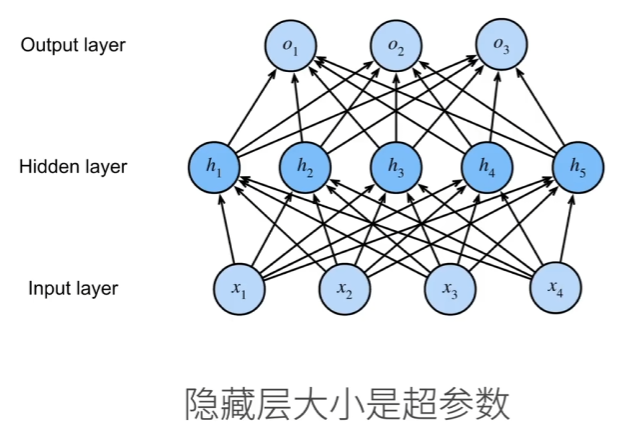
如何从x到o呢:
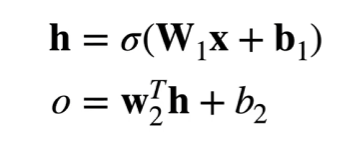
σ是一个激活函数:按元素做运算, 非线性(如果是一个线性函数, 就等价于一个单层的感知机);激活函数的一个作用是避免层数的塌陷

最经典的激活函数:Sigmoid函数;
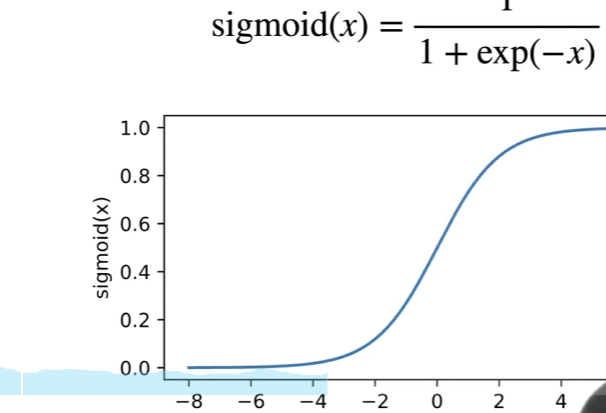
可以理解为, sigmoid函数时软化后的
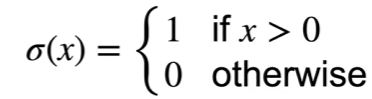
将输入投影到(0, 1)

Tanh激活函数: 和sigmoid类似, 将输入投影到了(-1, 1):
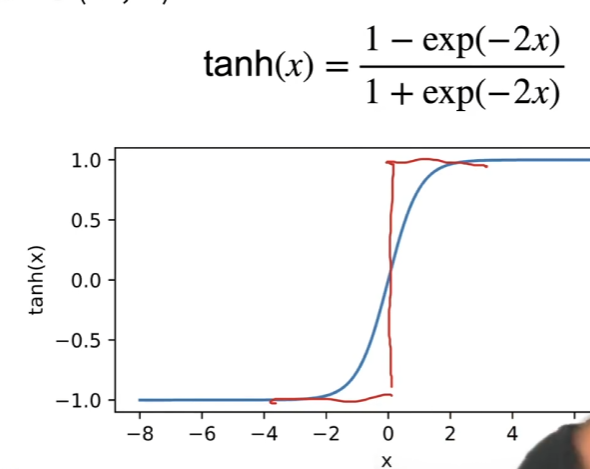
我们仍可以将其理解为一个硬函数的soft版本

ReLU(rectified linear unit)激活函数: 其实就是max(0, x)函数: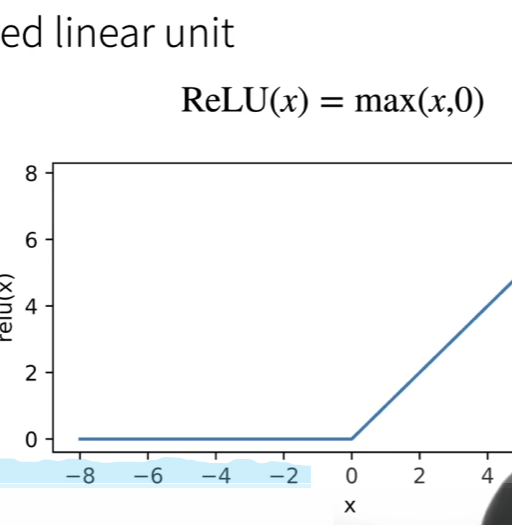

和我们之前学的softmax回归相比, 多类分类多了一层隐藏层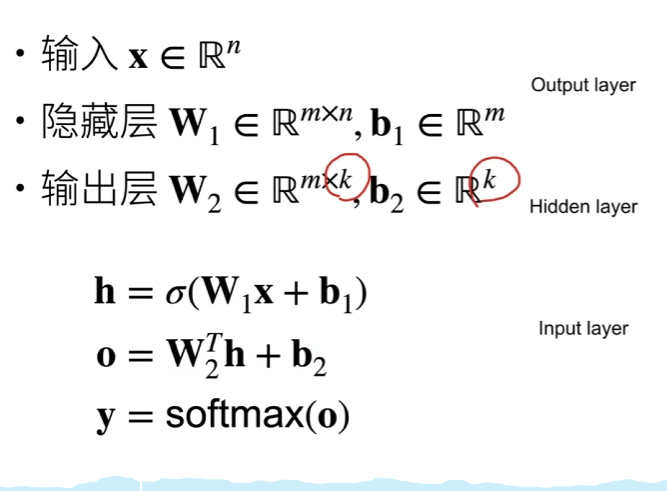
隐藏层变换 => 输出层变化 => 最后再来一层softmax得到y

我们可以做很多个隐藏层

In [1]:
# 多层感知机从零开始实现:
import torch
from torch import nn
from d2l import torch as d2l

#引入
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [ ]:
# 输入, 输出, 隐藏层(超参数)
# 784个神经元(28x28像素的图像) => 256个神经元 => 10个神经元（对应10分类任务）
num_inputs, num_outputs, num_hiddens = 784, 10, 256

# W1, W2使用正态分布随机初始化，并缩放到小数值（乘以0.01），避免初始激活值过大
# b1, b2初始化为零，这是神经网络中的常见做法

#第一层:
W1 = nn.Parameter(
    torch.randn(num_inputs, num_hiddens, requires_grad=True) * 0.01)
b1 = nn.Parameter(torch.zeros(num_hiddens, requires_grad=True))
#第二层:
W2 = nn.Parameter(
    torch.randn(num_hiddens, num_outputs, requires_grad=True) * 0.01)
b2 = nn.Parameter(torch.zeros(num_outputs, requires_grad=True))

params = [W1, b1, W2, b2]

权重（W）的初始化：
使用torch.randn生成服从标准正态分布（均值为0，方差为1）的随机数。
通过乘以0.01缩小初始值，使权重接近零。这是为了避免激活值在初始阶段过大（尤其是在深层网络中），从而缓解梯度爆炸或消失问题。

​**nn.Parameter**：
将普通张量（如W1, b1）包装为模型参数，使其在训练过程中自动计算梯度并更新。
使用model.parameters()时，这些参数会被优化器识别。

In [ ]:
# 实现ReLU激活函数
def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X, a)

In [ ]:
# 实现模型
def net(X):
    X = X.reshape((-1, num_inputs)) #将输入数据 X 从(batch_size, 28, 28)展平为 (batch_size, 784)。
    H = relu(X @ W1 + b1) # 矩阵乘法：X @ W1 实现输入层到隐藏层的线性变换; relu 函数引入非线性
    return (H @ W2 + b2) # 输出层直接返回线性结果（称为 ​logits），因为后续的 nn.CrossEntropyLoss 会隐式处理 Softmax 归一化

loss = nn.CrossEntropyLoss() # 隐式softmax处理 + 交叉熵计算

In [ ]:
# 执行训练代码(这个代码在上一章的, 这里运行不起来)
num_epochs, lr = 10, 0.1
updater = torch.optim.SGD(params, lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, updater)

In [ ]:
#简洁实现
import torch
from torch import nn
from d2l import torch as d2l

# 模型定义
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 256), nn.ReLU(), # 自动管理W1和b1并内置激活函数（替代手动调用relu）
                    nn.Linear(256, 10)) # 自动管理W2和b2

# 参数初始化
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01) # 正态分布初始化权重

net.apply(init_weights) # 自动遍历所有层并初始化

# 训练流程
batch_size, lr, num_epochs = 256, 0.1, 10
loss = nn.CrossEntropyLoss()
#net.parameters() 自动获取所有可训练参数，无需手动维护 params 列表。
trainer = torch.optim.SGD(net.parameters(), lr=lr)

# 数据集自动下载与预处理：无需手动实现数据下载、归一化、分批等操作。
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
# d2l.train_ch3 封装了训练循环、损失计算、精度评估等重复代码，无需手写 for epoch in range(num_epochs) 循环
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)